# Regularizers as memory

The greatest challenge in modern AI research is the limiting returns computational work. 
While the greatest advances can only be afforded by large technology firms, even they 
cannot afford to push results further. A clear plateau has developed. 
Insufficient computational efficiency motivates a return to theory, begs a question: 
_where is waste most significant?_ 

The advent of catestrophic forgetting shows raw, non-compressed information must be continually re-applied 
if it is not to be forgotten. If important information could be preserved--even partially--we would expect 
more efficient computation. In short, _this work targets the realization of memory_.

Regularized likelihood equations have a Lagrangian form, so implicitly describe geometric constraints on estimates.
For example, here's an estimate constrained to an L2-sphere in $\Theta$-space.

$$ \hat \theta_{L_2} = \text{arg max}_{\theta \in \Theta} n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) - \lambda \| \theta \|_2^2 $$

In this work, we'll generalize the regularizer $\| \cdot \|_2^2$ to support alternative geometries, 
in attempting to construct numerically convenient memory approximations. 
Particulary, we'll seek to approximate the following equation.
Note that it introduces quadratic geometric constraints on the estimate. 

$$ \hat \theta = \text{arg max}_{\theta \in \Theta} n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) - \frac{\lambda}{2} (\theta - \theta_0)^T \mathcal{I}_{\theta_0} (\theta - \theta_0) $$

## RL-reweighted (RLR) estimates 

This first estimate is designed to improve efficiency of sampling in reinforcement learning (RL) by 
up-weighting more-important observations. We'll use this estimate:

$$ \hat \theta_{RLR} = \hat \theta_{n_1+n_2} = \text{arg max}_\theta \left( \sum_{i=1}^{n_1+n_2} \| \hat r_i \|_2^{2b} \right)^{-1} \left( \sum_{i=n_1+1}^{n_1+n_2} \| \hat r_i \|_2^{2b} \log f_X(X_i; \theta) - \sum_{i=1}^{n_1} \frac{\lambda}{2} (\theta - \hat \theta_{n_1+n_2-1})^T H_i (\theta - \hat \theta_{n_1+n_2-1}) \right) $$

where 
- $n_1$ is the number of priviously observed sameples, 
- $n_2$ is the number of newly observed samples, 
- $\hat r_i$ is the estimated reward for observation $i$, 
- $b > 0$ is a bias term,  
- $H_i = \| \hat r_i \|^{2b}_2 \left( \nabla_\theta \log f_X(X_j; \theta)|_{\theta = \hat \theta_{j-1}} \right) \left( \nabla_\theta \log f_X(X_j; \theta)|_{\theta = \hat \theta_{j-1}} \right)^T$ is a Hessian approximation, and
- $\hat \theta_0$ is an initial estimate guess, commonly required in optimization routines. 

Define $ M:= \sum_{i=1}^{n_1}(\theta - \theta_{n_1+n_2-1})^TH_i(\theta - \theta_{n_1+n_2-1})$, which we'll refer to as the "memory term". 
The key heuristic is that $M$, a quadratic regularizer, approximates large-sample likelihoods under maximization. 
This insight can be seen through a Taylor approximation near true $\theta$, designated $\theta_T$.

$\hat \theta_{MLE} = \text{arg max}_\theta n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) $

$ \approx \text{arg max}_\theta n^{-1}\sum_i \log f_X(X_i; \theta_T) + n^{-1}\sum_i (\theta - \theta_T)^T \nabla_\theta \log f_X(X_i; \theta_T) + n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

$ \approx \text{arg max}_\theta n^{-1}\sum_i \log f_X(X_i; \theta_T) + 0 + n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

$ \approx \text{arg max}_\theta n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

This work basically tests the quality of our $M \approx \sum_i (\theta - \theta_T)^T (\nabla_\theta)^2 \log f_X(X_i; \theta_T)(\theta - \theta_T) $ heuristic.
If true, then we should see that the quadratic regularizer, $M$, affects memory through geometric constraints on the estimator.

Later, we'll experiment with recency bias and rank reductions for $M$.

Notice that $\hat \theta_{RLR}$ is asymptotically equivalent to a redistributed sampling, 
with more observations when they are more important. 
Hence, the essence of this computational efficiency strategy is to 
- add frequency bias to important observations, 
- and preserve their information via geometric estimator constraints.

## $M$ and almost-stationary processes

$M$ is an asymptotic result, so only applies when observations are sufficiently many and produced by a stationary or i.i.d process.
While most applied asymptotic theory assumes $\theta_T$ is static, it could also be possible to work with a $\theta_{T_n}$ on a continuous path in $\Theta$ over $n$.
Let us define an _almost-stationary process_ $X_n$ as satisfying the following.

$$ \forall \tau \in \mathbb{R}, \left(t_1, t_2, \ldots, t_m\right) \in \mathbb{R}_{\geq 0}^m, \mathbb{P}\left[ X_{t_{1+\tau}}, X_{t_{2+\tau}}, \ldots, X_{t_{m+\tau}} ; \theta_{t_1+\tau} \right] \text{is continuous in } \tau$$

The question of whether $\theta_{T_n}$ moves "too quickly" is dependent on an given process. 
If, for $n$ large, $M$ still approximates $\sum_i (\theta - \theta_{T_n})^T (\nabla_\theta^2 \log f_X(X_i; \theta_{T_n}))(\theta - \theta_{T_n})$, 
then we'll say $\theta_{T_n}$ is "sufficiently slow". Here are some examples relating to **transfer learning**.
- If we withheld digits 1 & 2 from MNIST for the first 10000 observations, then started including them afterward, 
we should expect $\theta_{T_n}$ to move too quickly. 
- As reinforcement learning (RL) agent explores its world, it's sampling process indeed deforms, albeit slowly. 
This context should have good opportunities for sufficiently slow changes in $\theta_{T_n}$. 
So, our experiments will focus on RL applications.

Developing transfer learning mechanisms for RL is particularly valuable, 
since it is frequently imagined to be a path to artificial general intelligence (AGI).

Side node: almost-stationary process theory clearly needs development. 
My experience has taught me to test the value of theoretical hypotheses before developing them, 
since theoretical development is far more expensive than computational experimentation.
I am confident in this hypothesis, because my previous theoretical developments are very similar. 
Any new proofs would not be very novel, and would be mere adaptations of prior work. 

## Experiment 1: Cartpole

We start with a _very_ simple example, proving-out concepts.

  0%|          | 0/10000 [00:00<?, ?it/s]/mnt/batch/tasks/shared/LS_root/mounts/clusters/wdurno1/code/Users/wdurno/notebooks/regularizers-as-memory/regmem.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  env_state = torch.tensor(env_state).float()
/mnt/batch/tasks/shared/LS_root/mounts/clusters/wdurno1/code/Users/wdurno/notebooks/regularizers-as-memory/regmem.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (env_state, reward, done, info, prev_env_state, action) in obs]
100%|██████████| 10000/10000 [02:11<00:00, 75.87it/s]


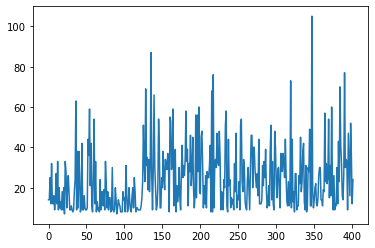

In [1]:
from regmem import Model 
model = Model() 
_ = model.simulate(total_iters=10000, plot_prob_func=False) 
#_ = model.simulate(total_iters=10, plot_prob_func=False) ## DEBUGGING

In [2]:
## testing memory 
model.convert_observations_to_memory()
_ = model.simulate(total_iters=10000, plot_prob_func=False) 

NameError: name 'model' is not defined